In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as PImage, PIL.ImageShow as PImageShow
import os
import os.path as osp
import torch

In [2]:
%matplotlib inline
torch.set_printoptions(sci_mode=False)

# Load model

In [3]:
from models import build_vae_var

setattr(torch.nn.Linear, 'reset_parameters', lambda _: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda _: None)  # disable default parameter init for faster speed

MODEL_DEPTH = 16
assert MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt = f'state_dicts/vae_ch160v4096z32_d{MODEL_DEPTH}.pth'
var_ckpt = f'state_dicts/var_d{MODEL_DEPTH}.pth'

if not osp.exists(vae_ckpt):
    vae_ckpt_old = vae_ckpt.replace(f"_d{MODEL_DEPTH}", "")
    os.system(f'wget {hf_home}/{vae_ckpt_old}')
    os.rename(vae_ckpt_old, vae_ckpt)
if not osp.exists(var_ckpt):
    os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (16/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422
prepare finished.


# Define sampling process

In [4]:
# set args
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

In [5]:
from imagenet_classes import IMAGENET_CLASSES # for human-friendly class names

def generate_images(
    batch_size: int,
    class_label: int,
    cfg: int | float | list[torch.Tensor],
    use_attn: bool = False,
    more_smooth: bool = False
):
    nrows = 2 if use_attn else 1
    ncols = len(patch_nums) if batch_size == 1 else batch_size
    figsize = (2.5 * batch_size, 5.25) if use_attn else (2.5 * len(patch_nums), 2.5)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    with torch.inference_mode():
        with torch.autocast("cuda", enabled=True, dtype=torch.float16, cache_enabled=True): # using bfloat16 can be faster
            im_B3HW = var.autoregressive_infer_cfg(
                B=batch_size,
                label_B=class_label,
                cfg=cfg,
                top_k=900,
                top_p=0.95,
                g_seed=seed,
                more_smooth=more_smooth,
                return_all_scales=batch_size==1
            )
    ax_ = ax[0] if use_attn else ax
    for j in range(ncols):
        ax_[j].axis("off")
        ax_[j].imshow(im_B3HW[j].cpu().float().permute(1, 2, 0))
    if use_attn:
        with torch.inference_mode():
            with torch.autocast("cuda", enabled=True, dtype=torch.float16, cache_enabled=True):
                im_B3HW_attn = var.autoregressive_infer_cfg(
                    B=batch_size,
                    label_B=class_label,
                    cfg=cfg,
                    top_k=900,
                    top_p=0.95,
                    g_seed=seed,
                    use_attn=True,
                    more_smooth=more_smooth,
                    return_all_scales=batch_size==1
                )
        for j in range(ncols):
            ax[1,j].axis("off")
            ax[1,j].imshow(im_B3HW_attn[j].cpu().float().permute(1, 2, 0))
    fig.subplots_adjust(hspace=0., wspace=0.)
    return fig

## Visualise image generation

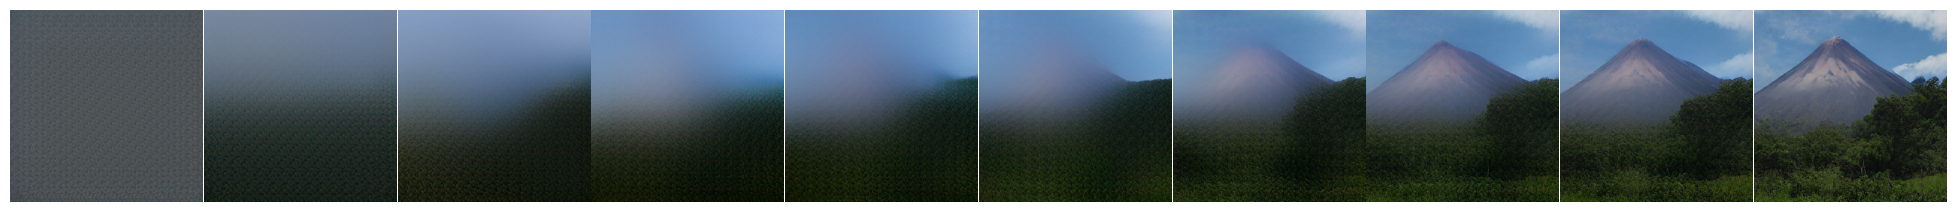

In [6]:
fig = generate_images(batch_size=1, class_label=980, cfg=4.)
fig.savefig(f"../figures/scales_{IMAGENET_CLASSES[980]}.png", transparent=True)

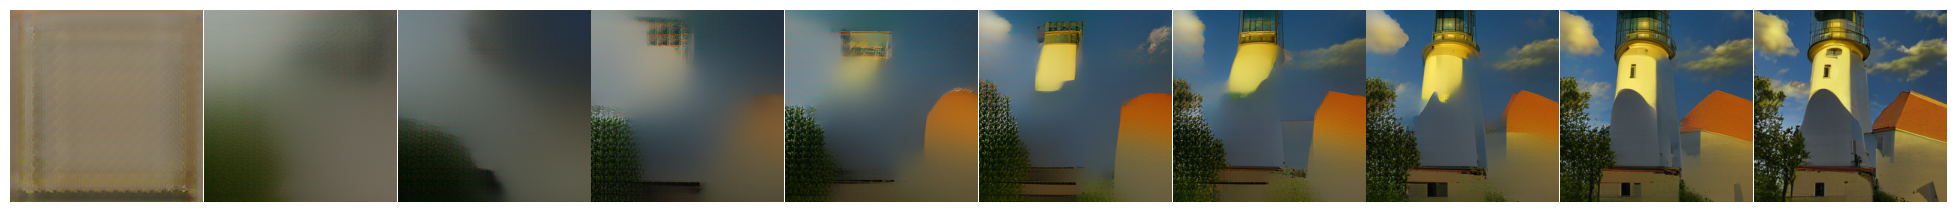

In [7]:
fig = generate_images(batch_size=1, class_label=437, cfg=4.)
fig.savefig(f"../figures/scales_{IMAGENET_CLASSES[437]}.png", transparent=True)

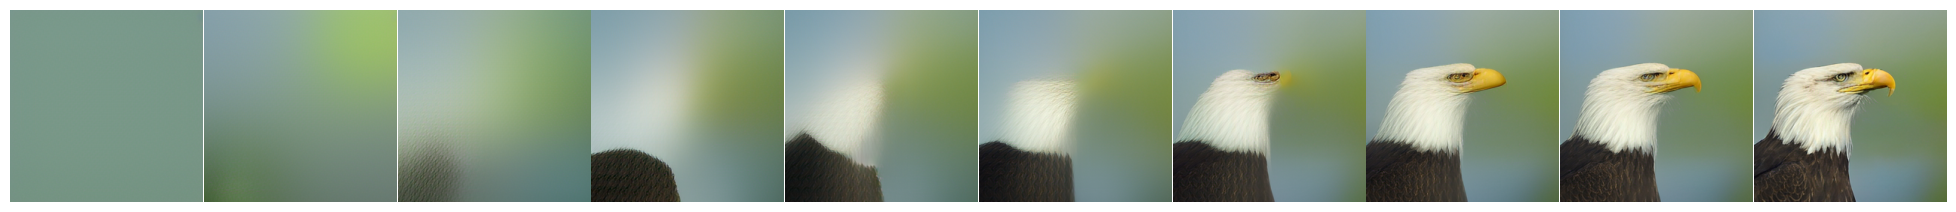

In [8]:
fig = generate_images(batch_size=1, class_label=22, cfg=4.)
fig.savefig(f"../figures/scales_{IMAGENET_CLASSES[22]}.png", transparent=True)

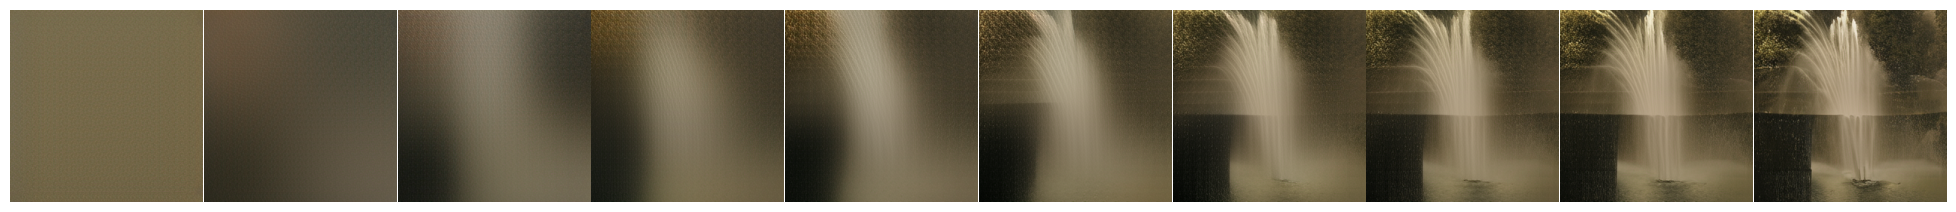

In [9]:
fig = generate_images(batch_size=1, class_label=562, cfg=4.)
fig.savefig(f"../figures/scales_{IMAGENET_CLASSES[562]}.png", transparent=True)

# Attention-based guidance



## Hyperparameters

In [10]:
batch_size = 10
class_label = 562
cfg_w = 4.

## Uniform guidance (default)

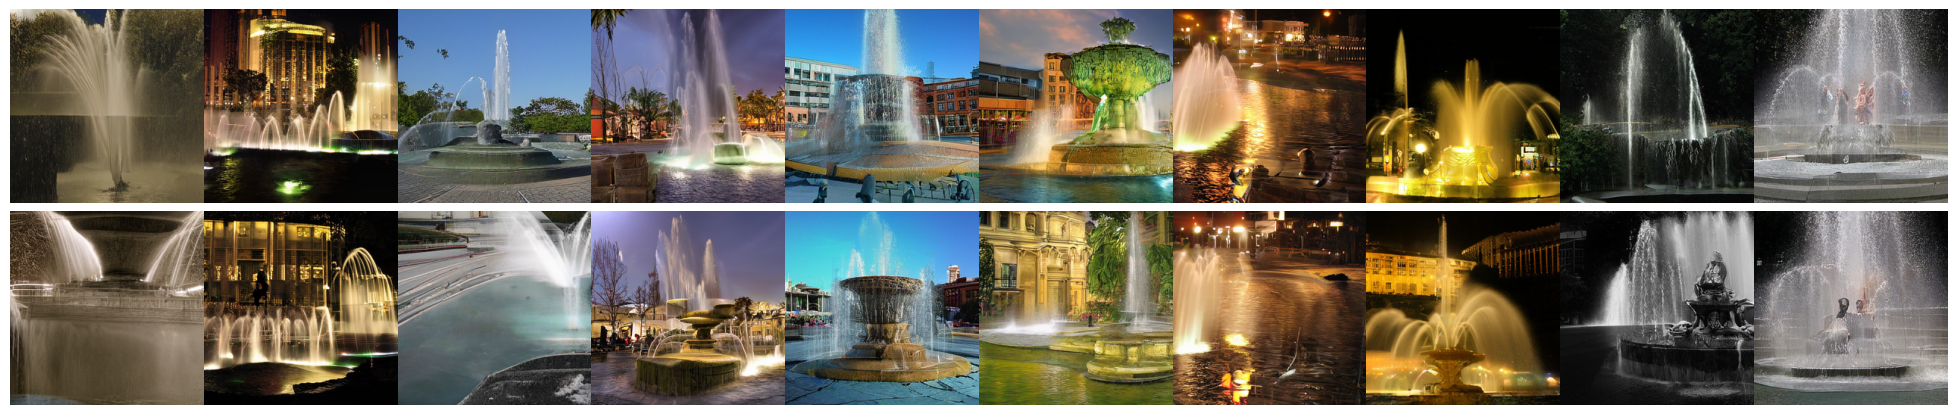

In [11]:
fig = generate_images(batch_size, class_label, cfg_w, use_attn=True)
# fig.savefig(f"../figures/attn_row_{IMAGENET_CLASSES[class_label].replace(' ', '-')}.png", transparent=True)

## Softmax guidance

In [ ]:
def softmax_cfg(d=.5):
    cfg = []
    for p in patch_nums:
        w = cfg_w * torch.eye(p**2)
        if w.shape[1] > 1:
            for i in range(w.shape[0]):
                w[i][:i] += w[i][i] * (1. - d) / (w.shape[1] - 1)
                w[i][i+1:] += w[i][i] * (1. - d) / (w.shape[1] - 1)
                w[i][i] *= d
        cfg.append(w)
    return cfg

In [ ]:
fig = generate_images(batch_size, class_label, softmax_cfg(), use_attn=True)

## Dropout guidance

In [ ]:
import random as rand

def dropout_cfg(r=.25):
    cfg = []
    for p in patch_nums:
        w = cfg_w * torch.eye(p**2)
        if w.shape[0] == 1:
            w[0,0] = 0.
        for i in range(w.shape[0]):
            w[i,i] *= rand.choices((0, 1), weights=(r, 1. - r))[0]
        cfg.append(w)
    return cfg

In [ ]:
fig = generate_images(batch_size, class_label, dropout_cfg(), use_attn=True)

## Softmax-dropout guidance

In [ ]:
import random as rand

def softdrop_cfg(r=.25, d=.5):
    cfg = []
    for p in patch_nums:
        w = cfg_w * torch.eye(p**2)
        if w.shape[0] == 1:
            w[0,0] = 0.
        for i in range(w.shape[0]):
            w[i,i] *= rand.choices((0, 1), weights=(r, 1. - r))[0]
            if w.shape[1] == 1:
                continue
            w[i][:i] += w[i][i] * (1. - d) / (w.shape[1] - 1)
            w[i][i+1:] += w[i][i] * (1. - d) / (w.shape[1] - 1)
            w[i][i] *= d
        cfg.append(w)
    return cfg

In [ ]:
fig = generate_images(batch_size, class_label, softdrop_cfg(), use_attn=True)